# Hackathon

Some utilities

## Import Utils

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.5/dist-packages


In [2]:
! pip install tables

In [3]:
!pip install keras

In [4]:
import keras
import h5py as h5
import numpy as np

PATH_DATA = '../full.h5'
PATH_PREDICT_WITHOUT_GT = '../pred_eighties_from_full_1_without_gt.h5'
PATH_SUBMIT = 'pred_from_full_Mostafa_Paul.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
BATCH_SIZE = 64
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [6]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [7]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    idxs = shuffle_idx(idxs)
    while True : 
        rd = np.random.randint(len(idxs)-10000)
        my_idxs = shuffle_idx(idxs[rd:rd+10000])
        batch_count = get_batch_count(my_idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = my_idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [8]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [9]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [10]:
print(train_batch_count*BATCH_SIZE, val_batch_count*BATCH_SIZE)

14958592 3739648


In [11]:
f = h5.File(PATH_DATA, 'r')

Y = f['TOP_LANDCOVER']
X = f['S2']


[ 1.  2.  3.  4.  5.  6.  9. 10. 11. 12. 13. 14. 15. 17. 18. 19. 20. 21.] [3827110 1250253 2315736  776966 2167443     633    3709 1112499  765705
 4054392    1281  634142    3847   86471    3829 1154414  538220    1590]


<Container object of 18 artists>

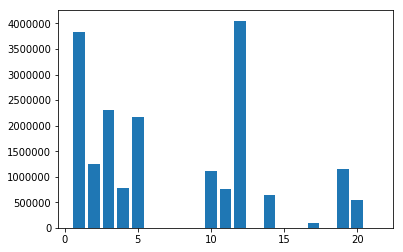

In [12]:

unique, counts = np.unique(Y, return_counts=True)
print(unique, counts)
from matplotlib import pyplot as plt
%matplotlib inline
plt.bar(unique, counts)




[[12 21]
 [ 1 20]
 [ 3 12]
 [ 5 11]
 [ 2  6]
 [19  6]
 [10  5]
 [ 4  4]
 [11  4]
 [14  3]
 [20  2]
 [17  0]
 [15  0]
 [18  0]
 [ 9  0]
 [21  0]
 [13  0]
 [ 6  0]]


<Container object of 18 artists>

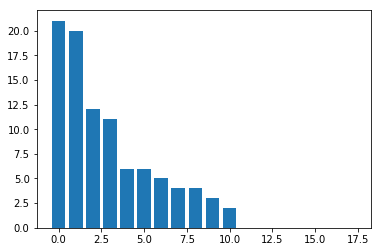

In [13]:
import operator 
occu = np.zeros((len(counts), 2))
occu[:, 0] = unique
occu[: ,1] = counts
occu = np.array(sorted(occu, key= operator.itemgetter(1,0), reverse= True))
occu = occu.astype(int)
occu
Total = np.sum(occu[:, 1])

occu[: ,1] = occu[: ,1]/Total*100
print (occu)
plt.bar(range(occu.shape[0]),occu[:, 1])

18
[[12 21]
 [ 1 41]
 [ 3 53]
 [ 5 64]
 [ 2 70]
 [19 76]
 [10 81]
 [ 4 85]
 [11 89]
 [14 92]
 [20 94]
 [17 94]
 [15 94]
 [18 94]
 [ 9 94]
 [21 94]
 [13 94]
 [ 6 94]]


<Container object of 18 artists>

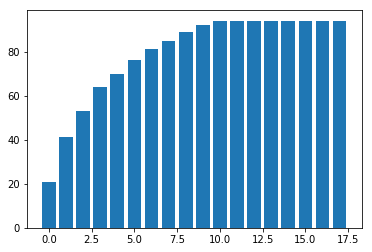

In [14]:
cum = np.copy(occu)
print(occu.shape[0])
for i in range(occu.shape[0]):
    cum[i, 1] = np.sum(occu[:i+1, 1])
    
print(cum)
plt.bar(range(occu.shape[0]),cum[:, 1])

In [15]:
list_99 = cum[:11, 0]
print(list_99)

[12  1  3  5  2 19 10  4 11 14 20]


In [16]:
nmb = len(Y)
idxs = range(nmb) 
#shuffled_idxs = shuffle_idx(idxs)
shuffled_idxs =idxs


In [17]:
np.random.seed(1)
from collections import Counter
import time
from sys import stdout
#intere = [12,  1,  3,  5,  2, 19, 10,  4, 11, 14, 20]
intere = [12,  1,  3,  5]
flags = [False]* len(intere)
images = []
label = []
counter ={}
seuil = 600000
i=0
k=0
a=0
while(True):
    lab = Y[shuffled_idxs[a+i],0]
    #print(lab)
    if lab in intere and counter.get(lab, 0) < seuil:
        #print(counter)
        images.append(X[shuffled_idxs[a+i]])
        label.append(intere.index(lab))
        counter[lab] = counter.get(lab, 0)+1
        if counter[lab]==seuil:
            flags[intere.index(lab)] = True
            #print(i)
    
    i=i+1
    
    if flags.count(True) == len(intere):
        print(k, "here")
        break
    
    if (k % 5000==0 and k!=0):
        #a = a + 10000 + np.random.randint(100000)
        a= a + 5000
        i = 0
    if (k % 100000==0):
        print(a, "\n", counter)
        stdout.flush()
    if (a == 6000000):
        a = 12700000
        i = 0
    if (a+i> nmb):
        break
    
    k=k+1
    
print(i)

0 
 {}
100000 
 {}
200000 
 {}
300000 
 {1.0: 34732, 3.0: 18914, 12.0: 5273, 5.0: 774}
400000 
 {1.0: 54536, 3.0: 45837, 12.0: 20925, 5.0: 1211}
500000 
 {1.0: 64401, 3.0: 72289, 12.0: 53443, 5.0: 1483}
600000 
 {1.0: 68850, 3.0: 100422, 12.0: 106115, 5.0: 1580}
700000 
 {1.0: 69681, 3.0: 106095, 12.0: 119396, 5.0: 34512}
800000 
 {1.0: 69793, 3.0: 107904, 12.0: 126098, 5.0: 100196}
900000 
 {1.0: 69888, 3.0: 109798, 12.0: 135544, 5.0: 169399}
1000000 
 {1.0: 69995, 3.0: 112469, 12.0: 148832, 5.0: 230549}
1100000 
 {1.0: 70072, 3.0: 115107, 12.0: 156009, 5.0: 302799}
1200000 
 {1.0: 70130, 3.0: 117178, 12.0: 158569, 5.0: 387768}
1300000 
 {1.0: 70386, 3.0: 121028, 12.0: 162382, 5.0: 456518}
1400000 
 {1.0: 74180, 3.0: 133516, 12.0: 173395, 5.0: 501052}
1500000 
 {1.0: 79757, 3.0: 156250, 12.0: 189253, 5.0: 537753}
1600000 
 {1.0: 86401, 3.0: 192217, 12.0: 206599, 5.0: 554592}
1700000 
 {1.0: 94522, 3.0: 233113, 12.0: 224921, 5.0: 567632}
1800000 
 {1.0: 98553, 3.0: 265872, 12.0: 254256

In [18]:
images = np.array(images)
label = np.array(label).astype(int).reshape(-1, 1)
print(images.shape)
print(label.shape)
print(counter)
print(k)

(2400000, 16, 16, 4)
(2400000, 1)
{1.0: 600000, 3.0: 600000, 12.0: 600000, 5.0: 600000}
5262863


In [19]:
print (label[:20])

[[2]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [2]
 [2]
 [1]
 [1]
 [2]]


In [20]:
idxs = range(images.shape[0])
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.1)

In [21]:
def generator(images, label, idxs, batch_size):
    
    while True : 
        idxs = shuffle_idx(shuffle_idx(shuffle_idx(idxs)))
        rd = np.random.randint(len(idxs)-300*batch_size)
        my_idxs = shuffle_idx(idxs[rd:rd+300*batch_size])
        batch_count = get_batch_count(my_idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = my_idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = images[batch_idxs, :,:,:]
            Y = label[batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), len(intere) )
            
train_gen = generator(images, label, train_idxs,BATCH_SIZE)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(images, label, train_idxs, BATCH_SIZE)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [22]:
print(train_batch_count, val_batch_count)

33750 3750


# Instanciation du model

In [23]:
input_shape = (16,16,4)

In [42]:
from keras.models import Model
from keras.layers import Input, Conv3D, Conv2D, Dropout, MaxPooling2D, Flatten, Activation, AveragePooling2D, concatenate, add


inp = Input(shape = input_shape)

#x1 = Conv2D(8, (3,3), padding = 'same')(inp)
#x1 = BatchNormalization(axis=-1)(x1)
#x1 = Activation("relu")(x1)
#x2 = Conv2D(8, (3,3), padding = 'same')(x1)
#x2 = BatchNormalization(axis=-1)(x2)

#conc0 = add([x1, x2])
#conc0 = Activation("relu")(conc0)

x3 = Conv2D(16, (5,5), padding = 'same')(inp)
x3 = BatchNormalization(axis=-1)(x3)
x3 = Activation("relu")(x3)
x3b = Conv2D(16, (5,5), padding = 'same')(x3)
x3b = BatchNormalization(axis=-1)(x3b)

conc1 = add([x3b, x3])
conc1 = Activation("relu")(conc1)

x4 = Conv2D(32, (3,3), padding = 'same')(conc1)
x4 = BatchNormalization(axis=-1)(x4)
x4 = Activation("relu")(x4)
x5 = Conv2D(32, (3,3), padding = 'same')(x4) 
x5 = BatchNormalization(axis=-1)(x5)

conc4 = add([x4, x5])
conc4 = Activation("relu")(conc4)

x6 = Conv2D(64, (3,3), padding = 'same')(conc4)
x6 = BatchNormalization(axis=-1)(x6)
x6 = Activation("relu")(x6)
x6b = Conv2D(64, (3,3), padding = 'same')(x6) 
x6b = BatchNormalization(axis=-1)(x6b)

conc5 = add([x6, x6b])
conc5 = Activation("relu")(conc5)

conc5 = MaxPooling2D(pool_size = (2,2))(conc5)

# add 256

out = Flatten()(conc5)


out = Dense(512)(out)
out = BatchNormalization()(out)
out = Activation("relu")(out)
out = Dropout(0.2)(out)
out = Dense(len(intere))(out)
out = Activation('softmax')(out)

model2 = Model(inp, out)

optim = keras.optimizers.Adam(lr=0.0001)
#optim = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model2.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16, 16, 4)    0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 16, 16, 16)   1616        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 16, 16, 16)   64          conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 16, 16, 16)   0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_30 

In [44]:
from keras.callbacks import EarlyStopping
cback = EarlyStopping(monitor ='loss', patience = 3, mode = 'min')

# Fit

In [46]:
history = model2.fit_generator(train_gen, steps_per_epoch=200, epochs=150, verbose=1, validation_data=val_gen,callbacks =[cback], nb_val_samples=150)

Epoch 1/150
  3/200 [..............................] - ETA: 8s - loss: 0.8684 - acc: 0.6302

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=200, validation_steps=150, verbose=1, callbacks=[<keras.ca..., validation_data=<generator..., epochs=150)`
  """Entry point for launching an IPython kernel.


200/200 [==============================] - 8s 42ms/step - loss: 0.8436 - acc: 0.6431 - val_loss: 0.8256 - val_acc: 0.6494
Epoch 2/150
200/200 [==============================] - 8s 41ms/step - loss: 0.8485 - acc: 0.6384 - val_loss: 0.8361 - val_acc: 0.6490
Epoch 3/150
200/200 [==============================] - 9s 46ms/step - loss: 0.8506 - acc: 0.6389 - val_loss: 0.8226 - val_acc: 0.6465
Epoch 4/150
200/200 [==============================] - 7s 36ms/step - loss: 0.8352 - acc: 0.6455 - val_loss: 0.8338 - val_acc: 0.6438
Epoch 5/150
200/200 [==============================] - 9s 46ms/step - loss: 0.8478 - acc: 0.6362 - val_loss: 0.8163 - val_acc: 0.6538
Epoch 6/150
200/200 [==============================] - 9s 46ms/step - loss: 0.8472 - acc: 0.6413 - val_loss: 0.8823 - val_acc: 0.6197
Epoch 7/150
200/200 [==============================] - 7s 36ms/step - loss: 0.8463 - acc: 0.6423 - val_loss: 0.9496 - val_acc: 0.5778


In [12]:

from keras.callbacks import EarlyStopping
cback = EarlyStopping(monitor ='loss', patience = 2, mode = 'min')
from keras.models import load_model
model = load_model("../postultimate_model.dqf")

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   592         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [34]:
model2.save("../postultimate_model_bfm_7.dqf")

## Prediction routines

In order to submit a result here are some gits

In [52]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [53]:
from keras.models import load_model
#model = load_model("../postultimate_model.dqf")
model = model2

In [54]:

pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700
1889/1889 [==============================] - 22s 12ms/step
241700


1

## Some ideas for monitoring

In [58]:
import pandas as pd
y_pred = np.argmax(prediction, axis = 1)
print(y_pred)
for i in range(y_pred.shape[0]):
    y_pred[i] = intere[y_pred[i]]
print(y_pred)

[0 2 1 ... 5 5 5]
[12  3  1 ... 19 19 19]


In [59]:

PATH_SUBMIT1 = "result_bfm_8.csv"
df2 = pd.DataFrame(y_pred, columns=['TOP_LANDCOVER'])
df2.to_csv(PATH_SUBMIT1, index_label="ID")

In [11]:
from keras.models import Model
from keras.layers import Input, Conv3D, Conv2D, Dropout, MaxPooling2D, Flatten, Activation, AveragePooling2D, concatenate, add


inp = Input(shape = input_shape)

#x1 = Conv2D(16, (3,3), padding = 'same')(inp)
#x1 = BatchNormalization(axis=-1)(x1)
#x1 = Activation("relu")(x1)
#x2 = Conv2D(16, (3,3), padding = 'same')(x1)
#x2 = BatchNormalization(axis=-1)(x2)

#conc0 = add([x1, x2])
#conc0 = Activation("relu")(conc0)

x3 = Conv2D(16, (3,3), padding = 'same')(inp)
x3 = BatchNormalization(axis=-1)(x3)
x3 = Activation("relu")(x3)
x3b = Conv2D(16, (3,3), padding = 'same')(x3)
x3b = BatchNormalization(axis=-1)(x3b)



conc1 = add([x3b, x3])
conc1 = Activation("relu")(conc1)

x4 = Conv2D(32, (3,3), padding = 'same')(conc1)
x4 = BatchNormalization(axis=-1)(x4)
x4 = Activation("relu")(x4)
x5 = Conv2D(32, (3,3), padding = 'same')(x4) 
x5 = BatchNormalization(axis=-1)(x5)

conc4 = add([x4, x5])
conc4 = Activation("relu")(conc4)

x6 = Conv2D(64, (3,3), padding = 'same')(conc4)
x6 = BatchNormalization(axis=-1)(x6)
x6 = Activation("relu")(x6)
x6b = Conv2D(64, (3,3), padding = 'same')(x6) 
x6b = BatchNormalization(axis=-1)(x6b)

conc5 = add([x6, x6b])
conc5 = Activation("relu")(conc5)

conc5 = MaxPooling2D(pool_size = (2,2))(conc5)

# add 256

out = Flatten()(conc5)


out = Dense(256)(out)
out = BatchNormalization()(out)
out = Activation("relu")(out)
out = Dropout(0.2)(out)
out = Dense(23)(out)
out = Activation('softmax')(out)

model2 = Model(inp, out)

optim = keras.optimizers.Adam(lr=0.0001)
#optim = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model2.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])